In [2]:
from pygenomeviz import GenomeViz
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import subprocess
import sys
sys.path.append('/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/analysis')
from transcriptomics import * 
from hcr import *
from plotting import * 

# Specify blast databases
new_transcriptome_db_no_introns = "../raw-data/OBir/mRNA_no_introns/mRNA_no_introns"
new_transcriptome_db_yes_introns = "../raw-data/OBir/mRNA_yes_introns/mRNA_yes_introns"
all_intergenic_regions_db = '../raw-data/OBir/intergenics/all_intergenic_regions'
all_lncRNAs_db = '../raw-data/OBir/lncRNAs/all_ORs_antisense'

# Load genome
genome_path = "../raw-data/OBir/genome/Obir.assembly.v5.4.fasta"
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_path, "fasta"))

# Load transcriptome
tr = load_transcriptome_object("../raw-data/OBir/transcriptome/biroi_transcriptome.pkl")

# Load or_db
or_db = pd.read_excel('../raw-data/OBir/ORs/OR List.xlsx') 

Initializing transcriptomics package
Initializing HCR package
Initializing plotting package


In [3]:
path_9e118_introns = "../raw-data/OBir/single_gene_intron_probe_design/probe_binding_regions_sheets/Or5-9E118-introns-B2-XM_020032758.2-regions-2025-06-19.xlsx"
path_9e118_exons = "../raw-data/OBir/single_gene_probe_design/probe_binding_regions_sheets/Or5-9E118-B1-XM_020032758.2-regions-2025-06-19.xlsx"

In [4]:
regions_9e118_introns = pd.read_excel(path_9e118_introns)
regions_9e118_introns = regions_9e118_introns["Region"].values

regions_9e118_exons = pd.read_excel(path_9e118_exons)
regions_9e118_exons = regions_9e118_exons["Region"].values

In [5]:
TA = 45 

# Get genes 
genes = or_db[or_db['tandem_array'] == TA]['gene_name'].values

# Get gene objects from tr 
gene_objects = [tr.get_gene(gene) for gene in genes]

# Print the number of genes 
print("Number of genes: ", len(gene_objects))

Number of genes:  22


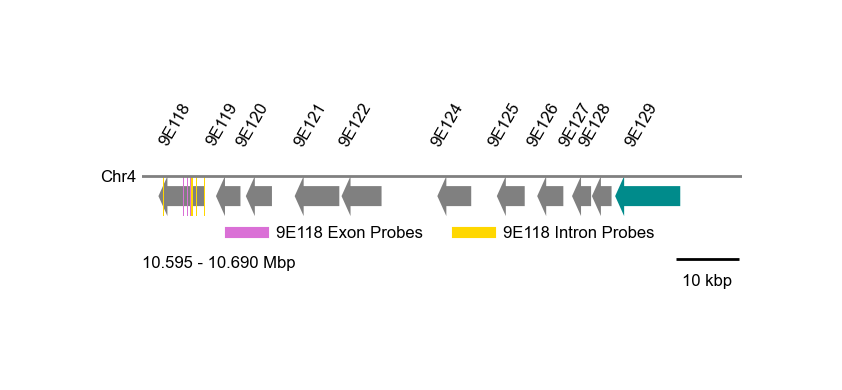

In [9]:
# Create a new GenomeViz object
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

gv = GenomeViz(track_align_type="center", theme="light", fig_width=3, fig_track_height=0.4)

# Get bounds 
probe_length = 50
chromosome = gene_objects[0].chromosome
bounds = [gene_object.get_transcript_longest_cds().get_bounds() for gene_object in gene_objects]
min_start = int(np.min(bounds)) - 1000
max_end = int(np.max(bounds)) + 1000

# 10,589,753-10,685,002
min_start = 10_595_000
max_end = 10_690_000

track = gv.add_feature_track(chromosome, segments = (int(min_start), int(max_end)), labelsize=6)

# Labels 
gv.set_scale_bar(ymargin=0.5, labelsize=6, scale_size_label=(10_000, "10 kbp"))
track.add_sublabel(size=6, ymargin=1, text=f"{(min_start/1_000_000):.3f} - {(max_end/1_000_000):.3f} Mbp")

# Add gene models to plot 
for gene in gene_objects:
    transcript = gene.get_transcript_longest_cds()
    bounds = transcript.get_bounds()
    strand = 1 if transcript.strand == '+' else -1
    if bounds[0] < min_start or bounds[1] > max_end:
        continue
    color = "darkcyan" if gene.name == "Or5-9E129" else "grey"
    track.add_feature(int(bounds[0]), 
                      int(bounds[1]), 
                      strand, 
                      plotstyle='arrow', 
                      fc=color, 
                      alpha=1, 
                      arrow_shaft_ratio = 0.5, 
                      label=re.sub("Or5-", "", gene.name), 
                      ec="black", 
                      lw=0, 
                      text_kws={'color': 'black', 
                                'rotation': 60, 
                                'vpos': 'top', 
                                'hpos': 'center', 
                                'size':6
                                }
                        )
    
    


# Get the region of the genome 
forward_seq = str(genome_seq[chromosome].seq[min_start:max_end]).upper()
reverse_seq = reverse_complement(forward_seq)

## 9E213 
# Annotate probe binding regions on forward strand 
for probe in regions_9e118_introns:
    positions = [m.start() for m in re.finditer(probe, forward_seq)]
    for position in positions:
        track.add_feature(min_start + position, min_start + position + probe_length, 1, plotstyle="box", label = '', ec="none", fc="orchid", alpha=1)
    # Add reverse complement
    positions = [m.start() for m in re.finditer(probe, reverse_seq)]
    for position in positions:
        track.add_feature(max_end - position - probe_length, max_end - position, -1, plotstyle="box", label = '', ec="none", fc="orchid", alpha=1)


## Intergenic 
# Annotate probe binding regions on forward strand 
for probe in regions_9e118_exons:
    positions = [m.start() for m in re.finditer(probe, forward_seq)]
    for position in positions:
        track.add_feature(min_start + position, min_start + position + probe_length, 1, plotstyle="box", label = '', ec="none", fc="gold", alpha=1)
    # Add reverse complement
    positions = [m.start() for m in re.finditer(probe, reverse_seq)]
    for position in positions:
        track.add_feature(max_end - position - probe_length, max_end - position, -1, plotstyle="box", label = '', ec="none", fc="gold", alpha=1)


fig = gv.plotfig(dpi=200)

## Artificial legend 
plt.plot([], color='orchid', label='9E118 Exon Probes', lw=4)
plt.plot([], color='gold', label='9E118 Intron Probes', lw=4)
fig.legend(loc='lower center', fontsize=6, bbox_to_anchor=(0.5, -0.5), ncol=3, frameon=False)

ax = fig.gca()
#ax.set_title("Tandem Array 79", fontsize=6, color='black', y=1.4)


fig.savefig(f"../figures/T45-Probes-9E118-introns.pdf", pad_inches=0, dpi=200)

plt.show()



In [7]:
tr.get_gene("Or5-9E129").get_transcript_longest_cds().get_bounds()[0] - tr.get_gene("Or5-9E118").get_transcript_longest_cds().get_bounds()[1]

65009